In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,material_7,material_8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,material_7,material_8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,material_7,material_8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,material_7,material_8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,material_7,material_8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


Some EDA

<AxesSubplot:ylabel='failure'>

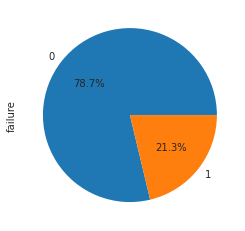

In [3]:
# target distribution pie chart
train_data.failure.value_counts().plot(kind='pie', autopct='%1.1f%%')

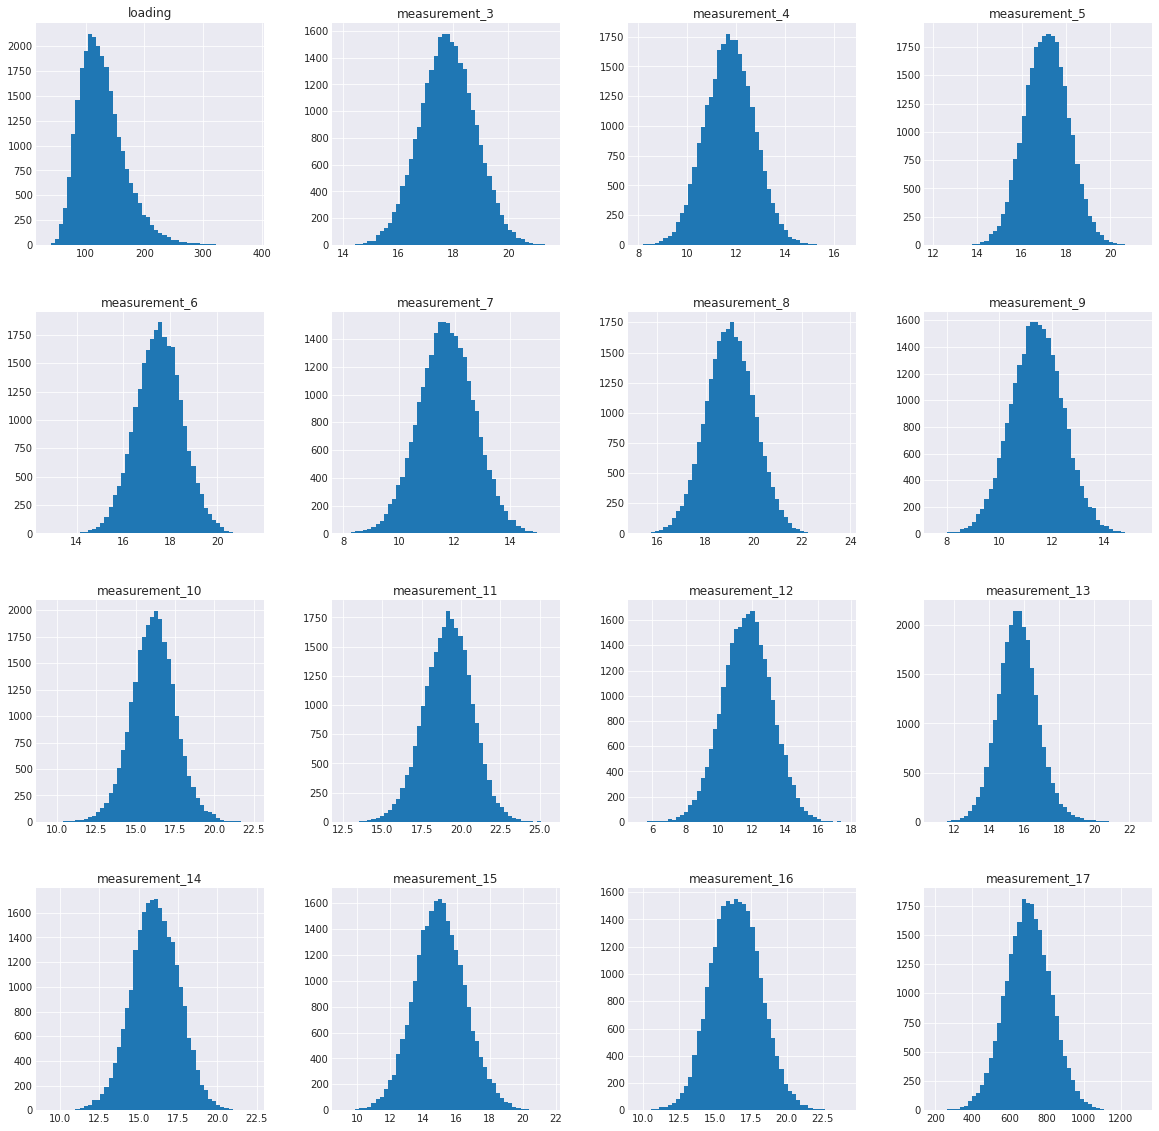

In [4]:
numerical_cols = train_data.select_dtypes(include=[ 'float64']).columns
# distribution of numerical columns
train_data[numerical_cols].hist(bins=50, figsize=(20,20))
plt.show()

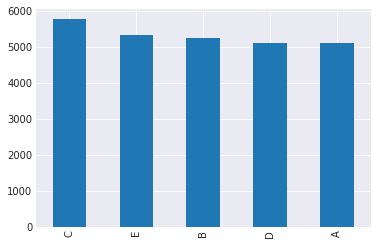

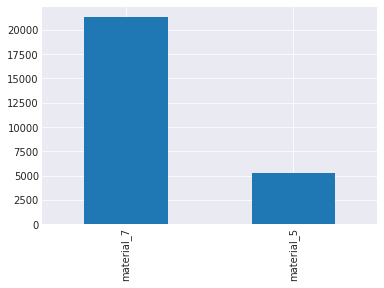

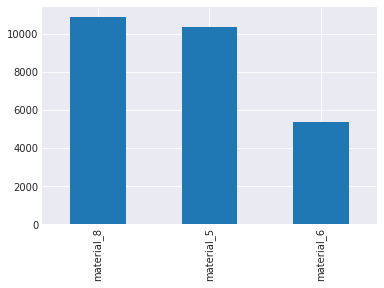

In [5]:
# categorical columns
categorical_cols = train_data.select_dtypes(include=[ 'object']).columns
# distribution of categorical columns
for col in categorical_cols:
    train_data[col].value_counts().plot(kind='bar')
    plt.show()

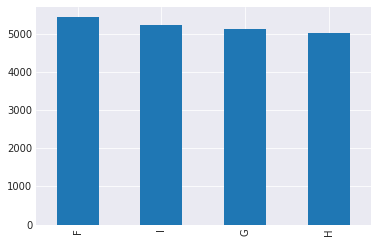

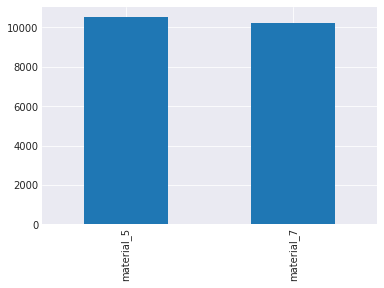

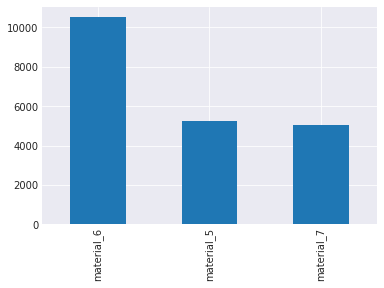

In [6]:
# categorical_cols in test_data
for col in categorical_cols:
    test_data[col].value_counts().plot(kind='bar')
    plt.show()

In [7]:
# missing values
train_data.isnull().sum()

id                   0
product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

In [8]:
test_data.isnull().sum()

id                   0
product_code         0
loading            223
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      329
measurement_4      409
measurement_5      508
measurement_6      624
measurement_7      720
measurement_8      846
measurement_9      904
measurement_10    1067
measurement_11    1136
measurement_12    1240
measurement_13    1303
measurement_14    1440
measurement_15    1542
measurement_16    1678
measurement_17    1740
dtype: int64

In [9]:
# def fillna(df, cols, values):    
#     new_df = df.copy()
#     for col in cols:
#         new_df[col] = new_df[col].fillna(values[col])
#     return new_df
# na_cols = train_data.columns[train_data.isnull().any()]
# median = train_data[na_cols].median()
# train = fillna(train_data, na_cols, median)
# test = fillna(test_data, na_cols, median)


In [10]:
from lightgbm import LGBMRegressor
class LightGBMInputer:
    def __init__(self,df,**lgb_params):
        self.df = df
        self.verbose = False
        self.lgb_params = lgb_params
        self.nan_cols = df.columns[df.isnull().any()]
    def impute(self):
        for col in self.nan_cols:
            if self.verbose:
                print('Imputing %s' % col)
            lightgbm = LGBMRegressor(**self.lgb_params)
            nan_index = self.df[col].isnull()
            train_index = ~nan_index
            X_train = self.df.loc[train_index,self.df.columns != col]
            y_train = self.df.loc[train_index,col]
            X_test = self.df.loc[nan_index,self.df.columns != col]
            lightgbm.fit(X_train,y_train,verbose=False)

            self.df.loc[nan_index,col] = lightgbm.predict(X_test)
        return self.df



    


In [11]:
train = train_data.copy()
test = test_data.copy()

In [12]:
# idea by ambroseM
train['m3_isna'] = train['measurement_3'].isna().astype(int)
test['m3_isna'] = test['measurement_3'].isna().astype(int)
train['m5_isna'] = train['measurement_5'].isna().astype(int)
test['m5_isna'] = test['measurement_5'].isna().astype(int)

# https://www.kaggle.com/competitions/tabular-playground-series-aug-2022/discussion/343368
train['measurement_(3*5)'] = train['measurement_3'] * train['measurement_5']
test['measurement_(3*5)'] = test['measurement_3'] * test['measurement_5']

train['missing_3*5'] = train['m3_isna'] * train['m5_isna']
test['missing_3*5'] = test['m3_isna'] * test['m5_isna']



Feature engineering idea by 
https://www.kaggle.com/code/desalegngeb/tps08-logisticregression-and-some-fe

In [13]:
train['area'] = train['attribute_2'] * train[   'attribute_3']
test['area'] = test['attribute_2'] * test['attribute_3']

# train.drop(['attribute_2', 'attribute_3'], axis=1, inplace=True)


In [14]:
# impute
train['attribute_0'] = train['attribute_0'].astype('category')
train['attribute_1'] = train['attribute_1'].astype('category')
test['attribute_0'] = test['attribute_0'].astype('category')
test['attribute_1'] = test['attribute_1'].astype('category')
# feature = [col for col in train if col not in ['failure','product_code','id']]



In [15]:
meas_gr1_cols = [f"measurement_{i:d}" for i in list(list(range(3, 17)))]
train['meas_avg'] = np.mean(train[meas_gr1_cols], axis=1)
test['meas_avg'] = np.mean(test[meas_gr1_cols], axis=1)
# train['std_gr1'] = np.std(train[meas_gr1_cols], axis=1)
# test['std_gr1'] = np.std(test[meas_gr1_cols], axis=1)
# train.drop(meas_gr1_cols, axis=1, inplace=True)
# test.drop(meas_gr1_cols, axis=1, inplace=True)

In [16]:
features = ['product_code', 'loading', 'measurement_0', 'measurement_1','attribute_0',
       'measurement_2',  'measurement_17',
        'm3_isna', 'm5_isna', 'measurement_(3*5)', 'missing_3*5',
       'area', 'meas_avg']

In [17]:
train.columns

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure', 'm3_isna', 'm5_isna', 'measurement_(3*5)', 'missing_3*5',
       'area', 'meas_avg'],
      dtype='object')

In [18]:

def fit(X_train, y_train, X_test, y_test,test_df,model):
    test =test_df.copy()
    # knn = KNNImputer(n_neighbors=3)
    # na_features = X_train.columns[X_train.isnull().any()]
    # knn.fit(X_train[na_features])
    # X_train[na_features] = knn.transform(X_train[na_features])
    # X_test[na_features] = knn.transform(X_test[na_features])
    features = [col for col in X_train.columns if col not in ['product_code','id']]
    cols_to_transform = ['attribute_0']
    X_train[cols_to_transform] = X_train[cols_to_transform].astype('category')
    X_test[cols_to_transform] = X_test[cols_to_transform].astype('category')
    lgb_params ={
        'boosting_type': 'gbdt',
        'max_depth': 3,
        'num_leaves': 20,
    }
    X_train = LightGBMInputer(X_train[features],**lgb_params).impute()
    X_test = LightGBMInputer(X_test[features],**lgb_params).impute()
    ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
    # tranforms
    train_ohe = ohe.fit_transform(X_train[cols_to_transform])

    test_ohe = ohe.transform(X_test[cols_to_transform])
    X_train.drop(cols_to_transform, axis=1, inplace=True)
    X_test.drop(cols_to_transform, axis=1, inplace=True)
    X_train[ohe.get_feature_names(cols_to_transform)] = train_ohe
    X_test[ohe.get_feature_names(cols_to_transform)] = test_ohe
    
    features2 = [col for col in X_train.columns if col not in ['product_code','id']]
    numerical_cols = X_train.select_dtypes(include=[ 'float64']).columns
    scaler = StandardScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test [numerical_cols] = scaler.transform(X_test [numerical_cols])
    model.fit(X_train[features2], y_train)

    y_pred = model.predict_proba(X_test[features2])[:,1]
    print('AUC:', roc_auc_score(y_test, y_pred))
    # test[na_features] = knn.transform(test[na_features])
    test[cols_to_transform] = test[cols_to_transform].astype('category')
    test = LightGBMInputer(test[features]).impute()
    test_ohe = ohe.transform(test[cols_to_transform])
    test_ohe = pd.DataFrame(test_ohe, columns=ohe.get_feature_names(cols_to_transform))
    test.drop(cols_to_transform, axis=1, inplace=True)
    test[ohe.get_feature_names(cols_to_transform)] = test_ohe

    test[numerical_cols] = scaler.transform(test[numerical_cols])
    
    test_pred = model.predict_proba(test[features2])[:,1]

    # importance = model.coef_.ravel()
    return test_pred,roc_auc_score(y_test, y_pred), y_pred

def fit_lightgbm(X_train, y_train, X_test, y_test,test_df, model):
    test =test_df.copy()
    
    # na_features = X_train.columns[X_train.isnull().any()]
    # knn.fit(X_train[na_features])
    # X_train[na_features] = knn.transform(X_train[na_features])
    # X_test[na_features] = knn.transform(X_test[na_features])
    features = [col for col in X_train.columns if col not in ['product_code','id']]
    cols_to_transform = ['attribute_0']
    X_train[cols_to_transform] = X_train[cols_to_transform].astype('category')
    X_test[cols_to_transform] = X_test[cols_to_transform].astype('category')
    lgb_params ={
        'boosting_type': 'gbdt',
        'max_depth': 2,
        'num_leaves': 20,
        'n_estimators':30
    }
    X_train = LightGBMInputer(X_train[features],**lgb_params).impute()
    X_test = LightGBMInputer(X_test[features],**lgb_params).impute()
    ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
    # tranforms
    
   # for lightgbm
    categorical_cols = train_data.select_dtypes(include=['category']).columns
    model.fit(X_train[features], y_train, eval_set=[(X_train[features], y_train), (X_test[features], y_test)],early_stopping_rounds=120, verbose=False)
    y_pred = model.predict_proba(X_test[features])[:,1]
    print('AUC:', roc_auc_score(y_test, y_pred))
    # test[na_features] = knn.transform(test[na_features])
    test = LightGBMInputer(test[features]).impute()

    test_pred = model.predict_proba(test[features])[:,1]
    # importance = model.feature_importances_
    return test_pred,roc_auc_score(y_test, y_pred), y_pred

def fit_fold(train,target, test,fit_logreg=True):
    """
    train: train data
    target: target
    test: test data
    fit_logreg: boolean, whether to fit logistic regression or Lightgbm
    """
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score=0
    test_pred = np.zeros(test.shape[0])
    y_pred = 0
   
    for train_index, test_index in kfold.split(train, target, groups=train['product_code']):
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
#         params = {
#     'n_estimators': 350,
#     'objective': 'binary',
#     'metric': 'auc',
#     'num_leaves': 34,
#     'learning_rate': 0.06,
#     'colsample_bytree':0.5,
#     'subsample':0.5,
#     'verbose': -1
# }
#         lgbm = LGBMClassifier(**params)
        if fit_logreg:
            logreg = LogisticRegression(penalty='l1', random_state=1, solver='liblinear',C= 0.01,class_weight = 'balanced') 
            test_pred_, score_, y_pred_ = fit(X_train, y_train, X_test, y_test,test,logreg)
        else:
            lgb_params ={
                 'boosting_type': 'gbdt',
                    'max_depth': 2,
                    'num_leaves': 20,
                    'learning_rate': 0.08,
                    'n_estimators': 20
                
            }

            model = LGBMClassifier(**lgb_params)
            test_pred_, score_, y_pred_ = fit_lightgbm(X_train, y_train, X_test, y_test,test,model)



        
        test_pred += test_pred_
        score += score_
        # y_pred += y_pred_
   
    
    return score/5, test_pred/5,y_pred/5



    


In [19]:
%%time
lightgbm_score , test_pred_lgb,y_pred = fit_fold(train[features], train.failure, test,fit_logreg=False)
print('Lightgbm score:', lightgbm_score)


AUC: 0.5918841067416741
AUC: 0.5864246856968814
AUC: 0.5951390886478621
AUC: 0.5788551836748507
AUC: 0.5871004585525982
Lightgbm score: 0.5878807046627733
CPU times: user 12.8 s, sys: 237 ms, total: 13.1 s
Wall time: 3.56 s


In [23]:
%%time
logreg_score , test_pred_logreg,y_pred = fit_fold( train[features], train.failure, test)
print('logreg_score:', logreg_score)
# 0.5900

AUC: 0.5967742993715164
AUC: 0.5928863009526387
AUC: 0.5964916919068004
AUC: 0.58057771705105
AUC: 0.5862332695984703
logreg_score: 0.5905926557760952
CPU times: user 17.6 s, sys: 1.12 s, total: 18.7 s
Wall time: 5.39 s


using logistic regression as final submission

In [42]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.failure = test_pred_logreg
sample_submission.to_csv('submission.csv', index=False)

In [44]:
import os
os.system('kaggle competitions submit -c "tabular-playground-series-aug-2022 " -f submission.csv -m "logreg submission"' )

100%|██████████| 511k/511k [00:02<00:00, 215kB/s]


Successfully submitted to Tabular Playground Series - Aug 2022

0

Next ensembling multiple model